## License
This file is part of the project hyperMusic. All of hyperMusic code is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. hyperMusic is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with hyperMusic. If not, see <https://www.gnu.org/licenses/>.

In [2]:
import os
import glob
import sys 

import bct as bct
import matplotlib.pyplot as plt
from mne.stats import fdr_correction
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

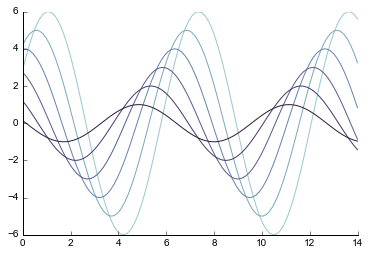

In [3]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    colors = sns.cubehelix_palette(7, start=.45, rot=-.45)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip, color = colors[i])
sinplot()
colors_palette = sns.cubehelix_palette(3, start=.45, rot=-.45)
sns.set_style("white")
sns.set_palette(colors_palette)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.show()

## List of tables
1. Participants' information

## List of figures

## Questions for committee
1. Check significance of participant information? Intraclass correlation? If so, how to check significance of this?
2. Narrow down deffense for one day

### First, we get some helper and anaysis functions going on...

In [10]:
def info_source(row):
    if row['sub_source'] == row['sub_leader']: 
        return 'leader'
    else:
        return 'follower'

def info_target(row):
    if row['sub_target'] == row['sub_leader']:
        return 'leader'
    else:
        return 'follower'
    
def monte_carlo_dist_unpaired(matrix_inputs):
    # concatenate both columns into one long vector
    n_vector = matrix_inputs.shape[0]
    long_vector = matrix_inputs.reshape((n_vector*2))

    # permute values
    perm_vector = np.random.permutation(long_vector)

    # unpack arrays
    a_out = perm_vector[n_vector:]
    b_out = perm_vector[:n_vector]

    # get ind t-test
    t_out, _ = sp.stats.ttest_ind(a_out, b_out)
    return t_out

# this bit of code runs paired t-tests instead of independent tests for the MonteCarlo simulation
def monte_carlo_dist(matrix_inputs):
    """Randomly swap entries in two arrays."""
    # indices to swap
    swap_inds = np.random.random(size = matrix_inputs.shape[0]) < 0.5
    
    # unpack the matrix
    a = matrix_inputs[:, 0]
    b = matrix_inputs[:, 1]
    
    # make copies of arrays a and b for output
    a_out = np.copy(a)
    b_out = np.copy(b)
    
    # swap values
    a_out[swap_inds] = b[swap_inds]
    b_out[swap_inds] = a[swap_inds]
    
    # calculate paired t-test
    t_out, _ = sp.stats.ttest_rel(a_out, b_out)

    return t_out
'''
condition = 'Insula Left,Parietal Right,leader,follower,beta,beta'
for condition in conditions:
    perm_cond = grand_grand_df[grand_grand_df['conditions'] == condition]
    perm_ste = perm_cond[['ste', 'baseline_ste']].values
    experimental_value, _ = sp.stats.ttest_rel(perm_ste[:, 0], perm_ste[:, 1]) # experimental value of paired t-test
    perm_distribution = np.array([monte_carlo_dist(perm_ste) for i in range(1000)])
    p_value = (experimental_value < perm_distribution).sum()/64.
    if p_value == 0.0:
        out_df.loc[out_df[out_df['conditions'] == condition].index[0], 'p_value'] = 1/64.
    else:
        out_df.loc[out_df[out_df['conditions'] == condition].index[0], 'p_value'] = p_value
'''

"\ncondition = 'Insula Left,Parietal Right,leader,follower,beta,beta'\nfor condition in conditions:\n    perm_cond = grand_grand_df[grand_grand_df['conditions'] == condition]\n    perm_ste = perm_cond[['ste', 'baseline_ste']].values\n    experimental_value, _ = sp.stats.ttest_rel(perm_ste[:, 0], perm_ste[:, 1]) # experimental value of paired t-test\n    perm_distribution = np.array([monte_carlo_dist(perm_ste) for i in range(1000)])\n    p_value = (experimental_value < perm_distribution).sum()/64.\n    if p_value == 0.0:\n        out_df.loc[out_df[out_df['conditions'] == condition].index[0], 'p_value'] = 1/64.\n    else:\n        out_df.loc[out_df[out_df['conditions'] == condition].index[0], 'p_value'] = p_value\n"

# Table 1: Participants' information

In [4]:
# get participants data
participants = pd.read_csv('data/participant_music.csv')
participants = participants[participants['Pair'] != 'P01']
participants = participants[participants['Pair'] != 'P02']
participants = participants[participants['Pair'] != 'P06']
participants = participants.reset_index()
del participants['index']

pairs = participants['Pair'].tolist()
n = len(pairs)/2
sub_df = pd.DataFrame(data=np.zeros((n, 13)), 
                      columns=['pair', 'age_1', 'age_2', 'formal_1', 
                               'formal_2', 'ensemble_1', 'ensemble_2', 
                               'conservatory_1', 'conservatory_2', 
                               'profesional_1', 'profesional_2',
                               'current_ensemble_1', 'current_ensemble_2'])              
sub_df['pair'] = pairs[::2]
sub_df['age_1'] = participants['age'][::2].tolist()
sub_df['age_2'] = participants['age'][1::2].tolist()
sub_df['formal_1'] = participants['formal_training'][::2].tolist()
sub_df['formal_2'] = participants['formal_training'][1::2].tolist()
sub_df['ensemble_1'] = participants['ensemble_training'][::2].tolist()
sub_df['ensemble_2'] = participants['ensemble_training'][1::2].tolist()
sub_df['conservatory_1'] = participants['conservatory'][::2].tolist()
sub_df['conservatory_2'] = participants['conservatory'][1::2].tolist()
sub_df['current_ensemble_1'] = participants['ensemble'][::2].tolist()
sub_df['current_ensemble_2'] = participants['ensemble'][1::2].tolist()
sub_df['profesional_1'] = participants['profesional'][::2].tolist()
sub_df['profesional_2'] = participants['profesional'][1::2].tolist()
sub_df

,pair,age_1,age_2,formal_1,formal_2,ensemble_1,ensemble_2,conservatory_1,conservatory_2,profesional_1,profesional_2,current_ensemble_1,current_ensemble_2
0,P03,23,20,15,12,10,8,Y,Y,N,Y,Y,N
1,P04,29,32,10,10,7,5,Y,Y,N,N,N,N
2,P05,20,18,10,15,6,4,Y,Y,N,N,Y,Y
3,P08,21,24,15,15,4,8,Y,Y,Y,N,N,N
4,P11,38,28,15,15,20,13,Y,Y,N,Y,N,N
5,P09,21,23,14,18,4,2,Y,Y,Y,Y,Y,N


# Analysis 1: Participants descriptive statistics

In [5]:
# pairs descriptive statistics: means and std's
mean_age = sub_df[['age_1', 'age_2']].values.mean()
std_age = sub_df[['age_1', 'age_2']].values.std()
mean_play = sub_df[['formal_1', 'formal_2']].values.mean()
std_play = sub_df[['formal_1', 'formal_2']].values.std()
mean_ensemble = sub_df[['ensemble_1', 'ensemble_2']].values.mean()
std_ensemble = sub_df[['ensemble_1', 'ensemble_2']].values.std()

# pairs descriptive statistics: absolute mean differences and std's
mean_diff = abs(sub_df[['age_2']].values - sub_df[['age_1']].values).mean()
std_diff= abs(sub_df[['age_2']].values - sub_df[['age_1']].values).std()
mean_diff_play = abs(sub_df[['formal_2']].values - sub_df[['formal_1']].values).mean()
std_diff_play = abs(sub_df[['formal_2']].values - sub_df[['formal_1']].values).std()
mean_diff_ens = abs(sub_df[['ensemble_2']].values - sub_df[['ensemble_1']].values).mean()
std_diff_ens = abs(sub_df[['ensemble_2']].values - sub_df[['ensemble_1']].values).std()

# pair descriptive statistics: characteristics
conserv_conc = (sub_df['conservatory_1'] == sub_df['conservatory_2']).sum()
prof_conc = (sub_df['profesional_1'] == sub_df['profesional_2']).sum()
ensemble_conc = (sub_df['current_ensemble_1'] == sub_df['current_ensemble_2']).sum()

descriptive_stats = (mean_age, std_age, mean_diff, std_diff,
                     mean_play, std_play, mean_diff_play, std_diff_play,
                     mean_ensemble, std_ensemble, mean_diff_ens, std_diff_ens, 
                     conserv_conc, prof_conc, ensemble_conc)

print('''
We tested 6 pianist dyads. 
Mean age: %f ± %f
Absolute mean age difference: %f ± %f

Mean formal music training: %f ± %f
Absolute mean formal music training difference: %f ± %f

Mean ensemble music training: %f ± %f
Absolute mean ensemble music training difference: %f ± %f

Conservatory education: %d/6 concordant
Currently working as profesional musicians: %d/6 concordant
Currently playing in an ensemble: %d/6 concordant'''%descriptive_stats)


We tested 6 pianist dyads. 
Mean age: 24.750000 ± 5.643950
Absolute mean age difference: 3.833333 ± 2.793842

Mean formal music training: 13.666667 ± 2.460804
Absolute mean formal music training difference: 2.000000 ± 2.081666

Mean ensemble music training: 7.583333 ± 4.733891
Absolute mean ensemble music training difference: 3.166667 ± 1.863390

Conservatory education: 6/6 concordant
Currently working as profesional musicians: 3/6 concordant
Currently playing in an ensemble: 4/6 concordant


# Analysis 2: Are there differences between playing and baseline? Furthermore: are there differences between actual pairs and shuffled pairs? (Average across all pieces and only look at between connections)

First average all trials (regardless of piece) per pair and output the csv files as well as figures (just to make sure everything is Ok!)

In [109]:
# Start by setting up parameters and a couple helper functions
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = np.unique(pairs).tolist()
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Loop through all the delays and pairs 
for i_pair in range(len(pairs)):
    for i_delay in range(len(delays)):
        
        # Get the grand delay with the csv's corresponding to that delay and pair
        file_list = glob.glob('/Users/hectorOrozco/Desktop/hM_analysis/2-STE_graham/csv_grand_matrices/'+ 
                              pairs[i_pair] +'*'+delays[i_delay]+'.csv')
        file_list = file_list[1:] # do not take into consideration the all to all file
        grand_df = pd.read_csv(file_list[0], index_col = 0)
        for file in file_list[1:]:
            temp = pd.read_csv(file, index_col = 0)
            grand_df = grand_df.append(temp)

        # Get info direction from the csv
        grand_df['info_source'] = grand_df.apply(info_source, axis = 1)
        grand_df['info_target'] = grand_df.apply(info_target, axis = 1)
        
        # Average all trials and all pieces together
        grand_matrix = grand_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target'], 
                                    as_index=False)['ste'].mean()
        
        # Output the grand_matrix file at this point
        grand_matrix.to_csv('output/csv_pieces_baseline_perPair/'+pairs[i_pair]+'_delay'+delays_seconds[i_delay]+'.csv')
        
        # Consider these variables as categorical so they are ordered correctly when creating the figure
        grand_matrix.loc[:, 'neuro_source'] = pd.Categorical(grand_matrix['neuro_source'], 
                                                         categories=sources_aranged, ordered = True)
        grand_matrix.loc[:, 'neuro_target'] = pd.Categorical(grand_matrix['neuro_target'], 
                                                         categories=sources_aranged, ordered = True)
        grand_matrix.loc[:, 'freq_source'] = pd.Categorical(grand_matrix['freq_source'], 
                                                        categories=freq_aranged, ordered = True)
        grand_matrix.loc[:, 'freq_target'] = pd.Categorical(grand_matrix['freq_target'], 
                                                        categories=freq_aranged, ordered = True)
        grand_matrix = grand_matrix.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                            columns = ['freq_target', 'info_target', 'neuro_target'], 
                                            values = 'ste')
        
        # Create the figure
        fig, axs = plt.subplots(1,1, figsize=(30, 30))
        sns.heatmap(grand_matrix, cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5})
        plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
        plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
        plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
        plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
        axs.set_title('%s, %s delay' % ((pairs[i_pair]), delays_seconds[i_delay]), fontsize=15)
        plt.tight_layout
        
        # Save figure 
        fig.savefig('figs/hyperbrain_baseline_grand_average_perPair/'+pairs[i_pair]+'_delay'+delays_seconds[i_delay]+'.png')
        plt.close('all')

We do the same on the baselines!

In [121]:
# Start by setting up parameters and a couple helper functions
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = np.unique(pairs).tolist()
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Loop through all the delays and pairs 
for i_pair in range(len(pairs)):
    for i_delay in range(len(delays)):
        # Get the grand delay with the csv's corresponding to that delay and pair
        file_list = glob.glob('/Users/hectorOrozco/Desktop/hM_analysis/3-STE_baseline_graham/baseline_grand_matrices/'+ 
                              pairs[i_pair] +'*'+delays[i_delay]+'.csv')
        grand_df = pd.read_csv(file_list[0], index_col = 0)
        for file in file_list[1:]:
            temp = pd.read_csv(file, index_col = 0)
            grand_df = grand_df.append(temp)


        # Average all trials and all pieces together
        grand_matrix = grand_df

        # Output the grand_matrix file at this point
        grand_matrix.to_csv('output/csv_pieces_baseline_perPair/'+pairs[i_pair]+'_baseline_delay'+delays_seconds[i_delay]+'.csv')

        # Consider these variables as categorical so they are ordered correctly when creating the figure
        grand_matrix.loc[:, 'neuro_source'] = pd.Categorical(grand_matrix['neuro_source'], 
                                                         categories=sources_aranged, ordered = True)
        grand_matrix.loc[:, 'neuro_target'] = pd.Categorical(grand_matrix['neuro_target'], 
                                                         categories=sources_aranged, ordered = True)
        grand_matrix.loc[:, 'freq_source'] = pd.Categorical(grand_matrix['freq_source'], 
                                                        categories=freq_aranged, ordered = True)
        grand_matrix.loc[:, 'freq_target'] = pd.Categorical(grand_matrix['freq_target'], 
                                                        categories=freq_aranged, ordered = True)
        grand_matrix = grand_matrix.pivot_table(index = ['freq_source', 'sub_source', 'neuro_source'], 
                                            columns = ['freq_target', 'sub_target', 'neuro_target'], 
                                            values = 'ste')
        # Create the figure
        fig, axs = plt.subplots(1,1, figsize=(30, 30))
        sns.heatmap(grand_matrix, cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5})
        plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
        plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
        plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
        plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
        axs.set_title('baseline %s, %s delay' % ((pairs[i_pair]), delays_seconds[i_delay]), fontsize=15)
        plt.tight_layout

        # Save figure and csv file
        fig.savefig('figs/hyperbrain_baseline_grand_average_perPair/'+pairs[i_pair]+'_baseline_delay'+delays_seconds[i_delay]+'.png')
        plt.close('all')  

Now that we have the per pair average connections, we use permutations to evaluate the statistical significance of the difference between baseline and playing together

In [325]:
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = np.unique(pairs).tolist()
delays_seconds = ['20ms', '200ms', '1000ms']

for i_delay in range(len(delays)):
    # get grand dataframes for baseline and playing conditions
    file_list = glob.glob('/Users/hectorOrozco/Desktop/hM_analysis/output/csv_pieces_baseline_perPair/*_delay'+delays_seconds[i_delay]+'.csv')
    baseline_files = [file for file in file_list if file[79] == 'b']
    playing_files = [file for file in file_list if file[79] != 'b']

    baseline_grand_df = pd.read_csv(baseline_files[0], index_col = 0)
    for file in baseline_files[1:]:
        temp = pd.read_csv(file, index_col = 0)
        baseline_grand_df = baseline_grand_df.append(temp)

    playing_grand_df = pd.read_csv(playing_files[0], index_col = 0)
    for file in playing_files[1:]:
        temp = pd.read_csv(file, index_col = 0)
        playing_grand_df = playing_grand_df.append(temp)

    # get top .33% of the between connections based on the grand average 
    playing_mean_df = playing_grand_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target'], 
                                        as_index=False)['ste'].mean()
    playing_mean_df = playing_mean_df[playing_mean_df['info_source'] != playing_mean_df['info_target']] #only take between connections
    playing_mean_df = playing_mean_df.sort_values(by=['ste'], ascending = False).reset_index()
    playing_top_df = playing_mean_df.iloc[:48, :] # Only taking the .33% top between connections per delay

    # get these connections from playing dataframe
    playing_grand_df.loc[:,'temp'] = playing_grand_df.iloc[:,1:7].apply(lambda x: ",".join(x.astype(str)), axis=1)
    playing_top_grand_df = playing_grand_df[playing_grand_df.temp.isin(playing_top_df.iloc[:,1:7].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist())]

    # get these connections from baseline dataframe tricky part: baseline doesn't have a clear direction, so we take the average between source-target and target-source
    baseline_cols = ['neuro_source', 'neuro_target', 'freq_source', 'freq_target', 'sub_source', 'sub_target', 'trial', 'pair', 'ste']
    baseline_grand_df = baseline_grand_df.loc[:, baseline_cols]
    baseline_grand_df.loc[:,'temp'] = baseline_grand_df.iloc[:,:4].apply(lambda x: ",".join(x.astype(str)), axis=1)
    baseline_grand_df = baseline_grand_df[baseline_grand_df['sub_source'] != baseline_grand_df['sub_target']]
    baseline_top_grand_df = baseline_grand_df[baseline_grand_df.temp.isin(playing_top_df.iloc[:,[1, 2, 5, 6]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist())]
    
    # We get the average a-b and b-a from the baseline values 
    baseline_top_grand_df = baseline_top_grand_df.groupby(['neuro_source', 'neuro_target', 'freq_source', 'freq_target',
                                                           'pair'], as_index=False)['ste'].mean()
    baseline_top_grand_df.loc[:, 'temp'] = baseline_top_grand_df.iloc[:,[0, 1, 2, 3, 4]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()

    # We create the "grand grand" data frame with a column for the playing value and a column for the baselien value
    playing_top_grand_df.loc[:,'temp'] = playing_top_grand_df.iloc[:,[1, 2, 5, 6, 0]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    grand_grand_df = playing_top_grand_df.reset_index()
    for i_baseline in range(baseline_top_grand_df.shape[0]):
        for i_playing in range(grand_grand_df.shape[0]):
            if baseline_top_grand_df.loc[i_baseline, 'temp'] == grand_grand_df.loc[i_playing, 'temp']:
                grand_grand_df.loc[i_playing, 'baseline_ste'] = baseline_top_grand_df.loc[i_baseline, 'ste']

    # We loop across the top .33% edges; first get a list of these edges
    conditions = grand_grand_df.iloc[:,[2, 3, 4, 5, 6, 7]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    grand_grand_df['conditions'] = conditions
    conditions = np.unique(conditions)
    grand_grand_df = grand_grand_df.drop(['temp', 'index'], axis = 1)
    out_df = grand_grand_df.groupby(['neuro_source', 'neuro_target', 'freq_source', 'freq_target', 'info_source', 'info_target', 'conditions'], as_index=False)[('ste', 'baseline_ste')].mean()
    out_df['p_value'] = np.zeros(len(out_df))
    out_df['p_value_fdr'] = np.zeros(len(out_df))
    out_df['t_test'] = np.zeros(len(out_df))

    for condition in conditions:
        perm_cond = grand_grand_df[grand_grand_df['conditions'] == condition]
        perm_ste = perm_cond[['ste', 'baseline_ste']].values
        experimental_value, _ = sp.stats.ttest_ind(perm_ste[:, 0], perm_ste[:, 1]) # experimental value of ind t-test
        perm_distribution = np.array([monte_carlo_dist_unpaired(perm_ste) for i in range(5000)])
        p_value = (experimental_value < perm_distribution).sum()/5000.
        if p_value == 0.0:
            out_df.loc[out_df[out_df['conditions'] == condition].index[0], 'p_value'] = 1/5000.
        else:
            out_df.loc[out_df[out_df['conditions'] == condition].index[0], 'p_value'] = p_value
        out_df.loc[out_df[out_df['conditions'] == condition].index[0], 't_test'] = experimental_value  

    # now we do a false discovery rate procedure to control for fwer
    # we use the Benjamini and Yekutieli (BY--2001) modification, guarantees that the false discovery rate is kept where it should, but it is m ore conservative than the original BH procedure
    reject_fdr, pval_fdr = fdr_correction(out_df['p_value'].values, alpha = 0.05, method = 'negcorr')
    out_df['p_value_fdr'] = pval_fdr    
    out_df.to_csv('results/2.betweenVSbasline/top_connections_'+delays_seconds[i_delay]+'.csv')

Now that we have statistical threholds and all the values we are interested on, we plot all the data!

In [391]:
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = np.unique(pairs).tolist()
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Loop through all the delays and pairs 
for i_delay in range(len(delays)):
    file_list = glob.glob('/Users/hectorOrozco/Desktop/hM_analysis/output/csv_pieces_baseline_perPair/*_delay'+delays_seconds[i_delay]+'.csv')
    baseline_files = [file for file in file_list if file[79] == 'b']
    playing_files = [file for file in file_list if file[79] != 'b']

    baseline_grand_df = pd.read_csv(baseline_files[0], index_col = 0)
    for file in baseline_files[1:]:
        temp = pd.read_csv(file, index_col = 0)
        baseline_grand_df = baseline_grand_df.append(temp)

    playing_grand_df = pd.read_csv(playing_files[0], index_col = 0)
    for file in playing_files[1:]:
        temp = pd.read_csv(file, index_col = 0)
        playing_grand_df = playing_grand_df.append(temp)

    baseline_grand_df['sub_source'] = baseline_grand_df.iloc[:,[0, 7]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()    
    baseline_grand_df['sub_target'] = baseline_grand_df.iloc[:,[1, 7]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()

    sub_a_pairs = ['11A,P11', '3A,P03', '5A,P05', '5B,P04', '8A,P08', '9A,P09']
    sub_b_pairs = ['11B,P11', '4B,P03', '5B,P05', '6B,P04', '8B,P08', '9B,P09']
    baseline_grand_df.loc[baseline_grand_df['sub_source'].isin(sub_a_pairs), 'sub_source'] = 'a'
    baseline_grand_df.loc[baseline_grand_df['sub_target'].isin(sub_a_pairs), 'sub_target'] = 'a'
    baseline_grand_df.loc[baseline_grand_df['sub_source'].isin(sub_b_pairs), 'sub_source'] = 'b'
    baseline_grand_df.loc[baseline_grand_df['sub_target'].isin(sub_b_pairs), 'sub_target'] = 'b'
    
    # Average all edges
    baseline_matrix = baseline_grand_df.groupby(['neuro_source', 'neuro_target', 'sub_source', 'sub_target', 'freq_source', 'freq_target'], 
                                as_index=False)['ste'].mean()
    baseline_matrix.to_csv('results/2.betweenVSbasline/baseline_grand_delay'+delays_seconds[i_delay]+'.csv')
    # Consider these variables as categorical so they are ordered correctly when creating the figure
    baseline_matrix.loc[:, 'neuro_source'] = pd.Categorical(baseline_matrix['neuro_source'], 
                                                     categories=sources_aranged, ordered = True)
    baseline_matrix.loc[:, 'neuro_target'] = pd.Categorical(baseline_matrix['neuro_target'], 
                                                     categories=sources_aranged, ordered = True)
    baseline_matrix.loc[:, 'freq_source'] = pd.Categorical(baseline_matrix['freq_source'], 
                                                    categories=freq_aranged, ordered = True)
    baseline_matrix.loc[:, 'freq_target'] = pd.Categorical(baseline_matrix['freq_target'], 
                                                    categories=freq_aranged, ordered = True)
    baseline_matrix = baseline_matrix.pivot_table(index = ['freq_source', 'sub_source', 'neuro_source'], 
                                        columns = ['freq_target', 'sub_target', 'neuro_target'], 
                                        values = 'ste')

    # Create the figure
    fig, axs = plt.subplots(1,1, figsize=(30, 30))
    sns.heatmap(baseline_matrix, cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5})
    plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
    plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
    plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
    plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
    axs.set_title('baseline grand mean, %s delay' % delays_seconds[i_delay], fontsize=15)
    plt.tight_layout
    # Save figure and csv file
    fig.savefig('results/2.betweenVSbasline/baseline_grand_delay'+delays_seconds[i_delay]+'.png')
    
    # Average all trials and all pieces together
    playing_matrix = playing_grand_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target'], 
                            as_index=False)['ste'].mean()
    playing_matrix.to_csv('results/2.betweenVSbasline/playing_grand_delay'+delays_seconds[i_delay]+'.csv')
    
    # Consider these variables as categorical so they are ordered correctly when creating the figure
    playing_matrix.loc[:, 'neuro_source'] = pd.Categorical(playing_matrix['neuro_source'], 
                                                 categories=sources_aranged, ordered = True)
    playing_matrix.loc[:, 'neuro_target'] = pd.Categorical(playing_matrix['neuro_target'], 
                                                 categories=sources_aranged, ordered = True)
    playing_matrix.loc[:, 'freq_source'] = pd.Categorical(playing_matrix['freq_source'], 
                                                    categories=freq_aranged, ordered = True)
    playing_matrix.loc[:, 'freq_target'] = pd.Categorical(playing_matrix['freq_target'], 
                                                    categories=freq_aranged, ordered = True)
    playing_matrix = playing_matrix.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                        columns = ['freq_target', 'info_target', 'neuro_target'], 
                                        values = 'ste')

    # Create the figure
    fig, axs = plt.subplots(1,1, figsize=(30, 30))
    sns.heatmap(playing_matrix, cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5})
    plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
    plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
    plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
    plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
    axs.set_title('playing grand mean, %s delay' % delays_seconds[i_delay], fontsize=15)
    plt.tight_layout
    fig.savefig('results/2.betweenVSbasline/playing_grand_delay'+delays_seconds[i_delay]+'.png')
    plt.close('all')

In [402]:
# We now get the masked plots 
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = np.unique(pairs).tolist()
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

############
# Delay 10 #
############
playing_grand_df = pd.read_csv('results/2.betweenVSbasline/playing_grand_delay' + delays_seconds[0]+'.csv', index_col = 0)
playing_grand_df['conditions'] = playing_grand_df.iloc[:,0:6].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()    
playing_top = pd.read_csv('results/2.betweenVSbasline/top_connections_' + delays_seconds[0]+'.csv', index_col = 0)
conditions = playing_top['conditions'].tolist()
playing_grand_df.loc[~playing_grand_df['conditions'].isin(conditions), 'ste'] = 0
playing_matrix = playing_grand_df

# Consider these variables as categorical so they are ordered correctly when creating the figure
playing_matrix.loc[:, 'neuro_source'] = pd.Categorical(playing_matrix['neuro_source'], 
                                             categories=sources_aranged, ordered = True)
playing_matrix.loc[:, 'neuro_target'] = pd.Categorical(playing_matrix['neuro_target'], 
                                             categories=sources_aranged, ordered = True)
playing_matrix.loc[:, 'freq_source'] = pd.Categorical(playing_matrix['freq_source'], 
                                                categories=freq_aranged, ordered = True)
playing_matrix.loc[:, 'freq_target'] = pd.Categorical(playing_matrix['freq_target'], 
                                                categories=freq_aranged, ordered = True)
playing_matrix = playing_matrix.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                    columns = ['freq_target', 'info_target', 'neuro_target'], 
                                    values = 'ste')

# Create the figure
fig, axs = plt.subplots(1,1, figsize=(30, 30))
sns.heatmap(playing_matrix.iloc[72:, 72:], cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5}, vmax = 0.0024)
plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
axs.set_title('playing grand mean, %s delay' % delays_seconds[0], fontsize=15)
plt.tight_layout
fig.savefig('results/2.betweenVSbasline/playing_grand_delay_zoom'+delays_seconds[0]+'.png')
plt.close('all')

############
# Delay 96 #
############
playing_grand_df = pd.read_csv('results/2.betweenVSbasline/playing_grand_delay' + delays_seconds[1]+'.csv', index_col = 0)
playing_grand_df['conditions'] = playing_grand_df.iloc[:,0:6].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()    
playing_top = pd.read_csv('results/2.betweenVSbasline/top_connections_' + delays_seconds[1]+'.csv', index_col = 0)
conditions = playing_top['conditions'].tolist()
playing_grand_df.loc[~playing_grand_df['conditions'].isin(conditions), 'ste'] = 0
playing_matrix = playing_grand_df

# Consider these variables as categorical so they are ordered correctly when creating the figure
playing_matrix.loc[:, 'neuro_source'] = pd.Categorical(playing_matrix['neuro_source'], 
                                             categories=sources_aranged, ordered = True)
playing_matrix.loc[:, 'neuro_target'] = pd.Categorical(playing_matrix['neuro_target'], 
                                             categories=sources_aranged, ordered = True)
playing_matrix.loc[:, 'freq_source'] = pd.Categorical(playing_matrix['freq_source'], 
                                                categories=freq_aranged, ordered = True)
playing_matrix.loc[:, 'freq_target'] = pd.Categorical(playing_matrix['freq_target'], 
                                                categories=freq_aranged, ordered = True)
playing_matrix = playing_matrix.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                    columns = ['freq_target', 'info_target', 'neuro_target'], 
                                    values = 'ste')

# Create the figure
fig, axs = plt.subplots(1,1, figsize=(30, 30))
sns.heatmap(playing_matrix.iloc[:24, :24], cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5}, vmax = 0.0065)
plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
axs.set_title('playing grand mean, %s delay' % delays_seconds[1], fontsize=15)
plt.tight_layout
fig.savefig('results/2.betweenVSbasline/playing_grand_delay_zoom'+delays_seconds[1]+'.png')
plt.close('all')

#############
# Delay 480 #
#############
playing_grand_df = pd.read_csv('results/2.betweenVSbasline/playing_grand_delay' + delays_seconds[2]+'.csv', index_col = 0)
playing_grand_df['conditions'] = playing_grand_df.iloc[:,0:6].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()    
playing_top = pd.read_csv('results/2.betweenVSbasline/top_connections_' + delays_seconds[2]+'.csv', index_col = 0)
conditions = playing_top['conditions'].tolist() 
playing_grand_df.loc[~playing_grand_df['conditions'].isin(conditions), 'ste'] = 0
playing_matrix = playing_grand_df

# Consider these variables as categorical so they are ordered correctly when creating the figure
playing_matrix.loc[:, 'neuro_source'] = pd.Categorical(playing_matrix['neuro_source'], 
                                             categories=sources_aranged, ordered = True)
playing_matrix.loc[:, 'neuro_target'] = pd.Categorical(playing_matrix['neuro_target'], 
                                             categories=sources_aranged, ordered = True)
playing_matrix.loc[:, 'freq_source'] = pd.Categorical(playing_matrix['freq_source'], 
                                                categories=freq_aranged, ordered = True)
playing_matrix.loc[:, 'freq_target'] = pd.Categorical(playing_matrix['freq_target'], 
                                                categories=freq_aranged, ordered = True)
playing_matrix = playing_matrix.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                    columns = ['freq_target', 'info_target', 'neuro_target'], 
                                    values = 'ste')

# Create the figure
fig, axs = plt.subplots(1,1, figsize=(30, 30))
sns.heatmap(playing_matrix.iloc[:24, :24], cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5}, vmax = 0.0075)
plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
axs.set_title('playing grand mean, %s delay' % delays_seconds[2], fontsize=15)
plt.tight_layout
fig.savefig('results/2.betweenVSbasline/playing_grand_delay_zoom'+delays_seconds[2]+'.png')
plt.close('all')

In [403]:
# We now get the masked plots 
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = np.unique(pairs).tolist()
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

############
# Delay 10 #
############
baseline_grand_df = pd.read_csv('results/2.betweenVSbasline/baseline_grand_delay' + delays_seconds[0]+'.csv', index_col = 0)
baseline_grand_df.loc[baseline_grand_df['sub_source'] == baseline_grand_df['sub_target'], 'ste'] = 0
baseline_matrix = baseline_grand_df 

# Consider these variables as categorical so they are ordered correctly when creating the figure
baseline_matrix.loc[:, 'neuro_source'] = pd.Categorical(baseline_matrix['neuro_source'], 
                                             categories=sources_aranged, ordered = True)
baseline_matrix.loc[:, 'neuro_target'] = pd.Categorical(baseline_matrix['neuro_target'], 
                                             categories=sources_aranged, ordered = True)
baseline_matrix.loc[:, 'freq_source'] = pd.Categorical(baseline_matrix['freq_source'], 
                                                categories=freq_aranged, ordered = True)
baseline_matrix.loc[:, 'freq_target'] = pd.Categorical(baseline_matrix['freq_target'], 
                                                categories=freq_aranged, ordered = True)
baseline_matrix = baseline_matrix.pivot_table(index = ['freq_source', 'sub_source', 'neuro_source'], 
                                    columns = ['freq_target', 'sub_target', 'neuro_target'], 
                                    values = 'ste')

# Create the figure
fig, axs = plt.subplots(1,1, figsize=(30, 30))
sns.heatmap(baseline_matrix.iloc[72:, 72:], cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5}, vmax = 0.0024)
plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
axs.set_title('baseline grand mean, %s delay' % delays_seconds[0], fontsize=15)
plt.tight_layout
fig.savefig('results/2.betweenVSbasline/baseline_grand_delay_zoom'+delays_seconds[0]+'.png')
plt.close('all')

############
# Delay 96 #
############
baseline_grand_df = pd.read_csv('results/2.betweenVSbasline/baseline_grand_delay' + delays_seconds[1]+'.csv', index_col = 0)
baseline_grand_df.loc[baseline_grand_df['sub_source'] == baseline_grand_df['sub_target'], 'ste'] = 0
baseline_matrix = baseline_grand_df 

# Consider these variables as categorical so they are ordered correctly when creating the figure
baseline_matrix.loc[:, 'neuro_source'] = pd.Categorical(baseline_matrix['neuro_source'], 
                                             categories=sources_aranged, ordered = True)
baseline_matrix.loc[:, 'neuro_target'] = pd.Categorical(baseline_matrix['neuro_target'], 
                                             categories=sources_aranged, ordered = True)
baseline_matrix.loc[:, 'freq_source'] = pd.Categorical(baseline_matrix['freq_source'], 
                                                categories=freq_aranged, ordered = True)
baseline_matrix.loc[:, 'freq_target'] = pd.Categorical(baseline_matrix['freq_target'], 
                                                categories=freq_aranged, ordered = True)
baseline_matrix = baseline_matrix.pivot_table(index = ['freq_source', 'sub_source', 'neuro_source'], 
                                    columns = ['freq_target', 'sub_target', 'neuro_target'], 
                                    values = 'ste')

# Create the figure
fig, axs = plt.subplots(1,1, figsize=(30, 30))
sns.heatmap(baseline_matrix.iloc[:24, :24], cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5}, vmax = 0.0065)
plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
axs.set_title('baseline grand mean, %s delay' % delays_seconds[1], fontsize=15)
plt.tight_layout
fig.savefig('results/2.betweenVSbasline/baseline_grand_delay_zoom'+delays_seconds[1]+'.png')
plt.close('all')

#############
# Delay 480 #
#############
baseline_grand_df = pd.read_csv('results/2.betweenVSbasline/baseline_grand_delay' + delays_seconds[2]+'.csv', index_col = 0)
baseline_grand_df.loc[baseline_grand_df['sub_source'] == baseline_grand_df['sub_target'], 'ste'] = 0
baseline_matrix = baseline_grand_df 

# Consider these variables as categorical so they are ordered correctly when creating the figure
baseline_matrix.loc[:, 'neuro_source'] = pd.Categorical(baseline_matrix['neuro_source'], 
                                             categories=sources_aranged, ordered = True)
baseline_matrix.loc[:, 'neuro_target'] = pd.Categorical(baseline_matrix['neuro_target'], 
                                             categories=sources_aranged, ordered = True)
baseline_matrix.loc[:, 'freq_source'] = pd.Categorical(baseline_matrix['freq_source'], 
                                                categories=freq_aranged, ordered = True)
baseline_matrix.loc[:, 'freq_target'] = pd.Categorical(baseline_matrix['freq_target'], 
                                                categories=freq_aranged, ordered = True)
baseline_matrix = baseline_matrix.pivot_table(index = ['freq_source', 'sub_source', 'neuro_source'], 
                                    columns = ['freq_target', 'sub_target', 'neuro_target'], 
                                    values = 'ste')

# Create the figure
fig, axs = plt.subplots(1,1, figsize=(30, 30))
sns.heatmap(baseline_matrix.iloc[:24, :24], cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5}, vmax = 0.0075)
plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
axs.set_title('baseline grand mean, %s delay' % delays_seconds[2], fontsize=15)
plt.tight_layout
fig.savefig('results/2.betweenVSbasline/baseline_grand_delay_zoom'+delays_seconds[2]+'.png')
plt.close('all')

Now we get the correlations 

In [806]:
# We get, per delay, the top 9 connections and correlate them with the trial self reports
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = ['P03', 'P04', 'P05', 'P08', 'P09', 'P11']
delays_seconds = ['20ms', '200ms', '1000ms']


# Loop through all the delays and pairs 
for i_delay in range(len(delays)):
    # Get the grand delay with the csv's corresponding to that delay and pair
    for i_pair in range(len(pairs)):
        file_list = glob.glob('/Users/hectorOrozco/Desktop/hM_analysis/2-STE_graham/csv_grand_matrices/'+ 
                              pairs[i_pair] +'*'+delays[i_delay]+'.csv')
        file_list = file_list[1:] # do not take into consideration the all to all file
        if i_pair == 0:
            grand_df = pd.read_csv(file_list[0], index_col = 0)
            for file in file_list[1:]:
                temp = pd.read_csv(file, index_col = 0)
                grand_df = grand_df.append(temp)
        else: 
            for file in file_list:
                temp = pd.read_csv(file, index_col = 0)
                grand_df = grand_df.append(temp)

    # Get info direction from the csv
    grand_df['info_source'] = grand_df.apply(info_source, axis = 1)
    grand_df['info_target'] = grand_df.apply(info_target, axis = 1)

    # get conditions so we can select the top ones per delay
    grand_df['conditions'] = grand_df.iloc[:,[6, 7, 13, 14, 4, 5]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()   

    # Output the csv at this point
    grand_df.to_csv('results/2.betweenVSbasline/grand_trial_df'+delays_seconds[i_delay] +'.csv')
    playing_top = pd.read_csv('results/2.betweenVSbasline/top_connections_' + delays_seconds[i_delay]+'.csv', index_col = 0)

    # get only the top 9!
    playing_top_sorted = playing_top.sort_values(by='ste', ascending = False).reset_index(drop = True).iloc[:9, :]
    playing_top_sorted

    # create list of conditions and extract the trial level for each condition
    conditions = playing_top_sorted['conditions'].tolist()
    grand_df = grand_df.loc[grand_df['conditions'].isin(conditions)]
    grand_df.loc[:, 'scale'] = 'place_holder'
    grand_df.loc[:, 'score'] = 0

    # combine pair, piece, and trial 
    grand_df['conditions_pmpq'] = grand_df.iloc[:,[11, 9, 10]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    grand_df = grand_df.reset_index(drop = True)
    scales = ['synergy', 'synchrony', 'quality']

    # read the self reports csv and wrangle it a bit
    pmpq_self_reports = pd.read_csv('/Users/hectorOrozco/Desktop/hM_analysis/data/pmpq/pmpq.csv')
    pmpq_self_reports = pmpq_self_reports[pmpq_self_reports['pair'] != 'P01']
    pmpq_self_reports = pmpq_self_reports[pmpq_self_reports['pair'] != 'P02']
    pmpq_self_reports = pmpq_self_reports[pmpq_self_reports['pair'] != 'P06']
    pmpq_self_reports = pmpq_self_reports[pmpq_self_reports['scale'] != 'anxiety']
    pmpq_self_reports = pmpq_self_reports.groupby(['pair', 'trial', 'piece', 'scale'], as_index=False)['score'].mean()
    pmpq_self_reports.loc[:, 'piece'] = [pmpq_self_reports.loc[:, 'piece'][i][1:] for i in range(len(pmpq_self_reports))]
    pmpq_self_reports['conditions_pmpq'] = pmpq_self_reports.iloc[:,[0, 2, 1]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()

    # loop across scales
    for i_scale in range(len(scales)):
        pmpq_temp = pmpq_self_reports[pmpq_self_reports['scale'] == scales[i_scale]].reset_index(drop = True)
        temp = grand_df.copy()
        # Loop across grand df and pmpq temp to get all the data where it should go
        for i_pmpq in range(pmpq_temp.shape[0]):
            for i_top in range(temp.shape[0]):
                if pmpq_temp.loc[i_pmpq, 'conditions_pmpq'] == temp.loc[i_top, 'conditions_pmpq']:
                    temp.loc[i_top, 'score'] = pmpq_temp.loc[i_pmpq, 'score']
                    temp.loc[i_top, 'scale'] = pmpq_temp.loc[i_pmpq, 'scale']
        if i_scale == 0:
            grand_pmpq_df = temp.copy()
        else:
            grand_pmpq_df = grand_pmpq_df.append(temp.copy())
            
    # get correlation coefficients per condition
    scales = ['synergy', 'synchrony', 'quality']
    pmpq_df_corrs = grand_pmpq_df.copy()
    pmpq_df_corrs = pmpq_df_corrs.drop(columns = ['sub_source', 'sub_target', 'sub_leader', 'sub_follower', 'conditions_pmpq'])
    pmpq_df_corrs = pmpq_df_corrs.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target', 'scale', 'conditions'], 
                                        as_index=False)['ste'].mean()
    pmpq_df_corrs['corr_value'] = 0.0
    pmpq_df_corrs['corr_p'] = 0.0
    pmpq_df_corrs['conditions_pmpq'] = pmpq_df_corrs.iloc[:,[7, 6]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    grand_pmpq_df['conditions_pmpq'] = grand_pmpq_df.iloc[:,[15, 16]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    conditions = np.unique(grand_pmpq_df['conditions_pmpq'].tolist())

    for i_condition in range(len(conditions)):
        condition_pmpq = grand_pmpq_df[grand_pmpq_df['conditions_pmpq'] == conditions[i_condition]].reset_index(drop = True).copy()
        x_pmpq = condition_pmpq['score'].values
        y_pmpq = condition_pmpq['ste'].values
        corr_pmpq, p_pmpq = sp.stats.pearsonr(x_pmpq, y_pmpq)
        pmpq_df_corrs.loc[pmpq_df_corrs['conditions_pmpq'] == conditions[i_condition], 'corr_value'] = corr_pmpq
        pmpq_df_corrs.loc[pmpq_df_corrs['conditions_pmpq'] == conditions[i_condition], 'corr_p'] = p_pmpq
    pmpq_df_corrs.to_csv('results/2.betweenVSbasline/corr_delay' + delays_seconds[i_delay]+ '.csv')
    conditions = np.unique(grand_pmpq_df.conditions.tolist())
    sns.lmplot(x="score", y="ste", hue="scale", data=grand_pmpq_df, palette = colors_palette, sharex = False, sharey = False, legend = True, x_ci = None, fit_reg = False, col = 'conditions', col_wrap = 3)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    sns.despine()
    plt.tight_layout
    fig = plt.gcf()
    fig.savefig('results/2.betweenVSbasline/correlations'+delays_seconds[i_delay]+'.png')
    plt.close('all')

In [984]:
# just for the sake of completion, correct p values 
for i_delay in range(len(delays_seconds)):
    corr_df = pd.read_csv('results/2.betweenVSbasline/corr_delay'+delays_seconds[i_delay]+'.csv', index_col = 0)
    _, corr_df['corr_p_adjusted'] = fdr_correction(corr_df['corr_p'].values, alpha = 0.05, method = 'negcorr') 
    corr_df.to_csv('results/2.betweenVSbasline/corr_delay' + delays_seconds[i_delay]+ '.csv')

Now, we compare the top connections to the shuffled participants ones

In [83]:
# Start by setting up parameters and a couple helper functions
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
pairs = ['P03', 'P04', 'P05', 'P08', 'P09', 'P11']
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Loop through all the delays and pairs 
for i_delay in range(len(delays)):
    # Get the grand delay with the csv's corresponding to that delay and pair
    file_list = glob.glob('/Users/hectorOrozco/Desktop/hM_analysis/5-STE_scrambled_pairs/csv_scrambled_matrices/*'+delays[i_delay]+'.csv')
    grand_df = pd.read_csv(file_list[0], index_col = 0)
    for file in file_list[1:]:
        temp = pd.read_csv(file, index_col = 0)
        grand_df = grand_df.append(temp)

    # Get info direction from the csv
    grand_df['info_source'] = grand_df.apply(info_source, axis = 1)
    grand_df['info_target'] = grand_df.apply(info_target, axis = 1)

    # Average source pairs together and output csv 
    grand_matrix = grand_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target', 'pair_a'], 
                                as_index=False)['ste'].mean()
    grand_matrix.to_csv('results/2.betweenVSbasline/scrambled_grand_delay'+delays_seconds[i_delay]+'.csv')
    
    # get the conditions from the "top connections" files 
    top_connections = pd.read_csv('results/2.betweenVSbasline/top_connections_'+ delays_seconds[i_delay]+'.csv', index_col = 0)
    conditions = top_connections['conditions']
    conditions_grand_matrix = grand_matrix.iloc[:,0:6].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist() # "Insula Left,Parietal Right,leader,follower,beta,beta"
    grand_matrix['conditions'] = conditions_grand_matrix
    grand_matrix_scrambled = grand_matrix.copy()
    
    # Get the ste values per pair, you will need to read the grand_trial_df[delay] csv  
    scrambled_top = grand_matrix_scrambled[grand_matrix_scrambled.conditions.isin(conditions)].reset_index(drop = True)
    grand_top_df = pd.read_csv('results/2.betweenVSbasline/grand_trial_df'+delays_seconds[i_delay]+'.csv', index_col= 0)
    grand_top_df = grand_top_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target', 'pair'], as_index=False)['ste'].mean()
    conditions_grand_top = grand_top_df.iloc[:,0:6].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist() # "Insula Left,Parietal Right,leader,follower,beta,beta"
    grand_top_df['conditions'] = conditions_grand_top
    grand_top_df = grand_top_df[grand_top_df.conditions.isin(conditions)].reset_index(drop = True)
    
    # Add the "scrambled_ste", "p_value_scrambled", "p_value_scrambled_fdr", "t_test_scrambled" columns to the top_connections csv
    top_connections['scrambled_ste'] = 0.0
    top_connections['p_value_scrambled'] = 0.0
    top_connections['p_value_scrambled_fdr'] = 0.0
    top_connections['t_test_scrambled'] = 0.0

    # we loop across the conditions to run the permutation tests
    for condition in conditions:
        scrambled_condition = scrambled_top.loc[scrambled_top['conditions'] == condition, 'ste'].values
        playing_condition = grand_top_df.loc[grand_top_df['conditions'] == condition, 'ste'].values
        experimental_value, _ = sp.stats.ttest_ind(playing_condition, scrambled_condition) # experimental value of ind t-test
        perm_ste = np.concatenate((np.expand_dims(playing_condition, axis = 1), np.expand_dims(scrambled_condition, axis = 1)), axis = 1)
        perm_distribution = np.array([monte_carlo_dist_unpaired(perm_ste) for i in range(5000)])
        p_value = (experimental_value < perm_distribution).sum()/5000.
        top_connections.loc[top_connections.conditions.isin([condition]), 'scrambled_ste'] = scrambled_condition.mean()
        top_connections.loc[top_connections.conditions.isin([condition]), 'p_value_scrambled'] = p_value
        top_connections.loc[top_connections.conditions.isin([condition]), 't_test_scrambled'] = experimental_value

    # now we do a false discovery rate procedure to control for fwer
    # we use the Benjamini and Yekutieli (BY--2001) modification, guarantees that the false discovery rate is kept where it should, but it is m ore conservative than the original BH procedure
    reject_fdr, pval_fdr = fdr_correction(top_connections['p_value_scrambled'].values, alpha = 0.05, method = 'negcorr')
    top_connections['p_value_scrambled_fdr'] = pval_fdr    
    top_connections.to_csv('results/2.betweenVSbasline/scrambled_top_connections_'+delays_seconds[i_delay]+'.csv')

# Analysis 3: Are there differences in terms of graph theory between the different pieces?

We first get the csv's with all the trials for each piece separately

In [822]:
# Start by setting up parameters and a couple helper functions
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
delays_seconds = ['20ms', '200ms', '1000ms']
sources_aranged = ['Prefrontal Left', 'Insula Left', 'Motor Left', 'Temporal Left', 'Parietal Left', 'Occipital Left',
                   'Prefrontal Right', 'Insula Right', 'Motor Right', 'Temporal Right', 'Parietal Right', 'Occipital Right']
freq_aranged = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Loop through all the delays

for i_delay in range(len(delays)):
    # Load the grand delay file
    grand_df = pd.read_csv('results/2.betweenVSbasline/grand_trial_df'+delays_seconds[i_delay]+'.csv', index_col= 0)

    # Average trials but keep pieces separate 
    pieces = ['mel', 'can', 'clo', 'val']

    piece_matrix = grand_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target', 'piece'], 
                                as_index=False)['ste'].mean()

    # Output the grand_matrix file at this point
    piece_matrix.to_csv('results/3.graph_pieces/pieces_delay'+delays_seconds[i_delay]+'.csv')


    for i_piece in range(len(pieces)):
        # Consider these variables as categorical so they are ordered correctly when creating the figure
        duo_matrix = piece_matrix[piece_matrix['piece'] == pieces[i_piece]].reset_index(drop = True).copy()
        duo_matrix.loc[:, 'neuro_source'] = pd.Categorical(duo_matrix['neuro_source'], 
                                                         categories=sources_aranged, ordered = True)
        duo_matrix.loc[:, 'neuro_target'] = pd.Categorical(duo_matrix['neuro_target'], 
                                                         categories=sources_aranged, ordered = True)
        duo_matrix.loc[:, 'freq_source'] = pd.Categorical(duo_matrix['freq_source'], 
                                                        categories=freq_aranged, ordered = True)
        duo_matrix.loc[:, 'freq_target'] = pd.Categorical(duo_matrix['freq_target'], 
                                                        categories=freq_aranged, ordered = True)

        duo_matrix = duo_matrix.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                            columns = ['freq_target', 'info_target', 'neuro_target'], 
                                            values = 'ste')

        # Create the figure
        fig, axs = plt.subplots(1,1, figsize=(30, 30))
        sns.heatmap(duo_matrix, cmap='Blues', square=True, linewidths=.5, ax = axs, cbar_kws = {'shrink': 0.5})
        plt.hlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
        plt.hlines(range(24, 121, 24), 120, 0, linewidth = 1)
        plt.vlines(range(12, 121, 12), 120, 0, linewidth = 0.5, linestyle = '--')
        plt.vlines(range(24, 121, 24), 120, 0, linewidth = 1)
        axs.set_title('%s at %s delay' % ((pieces[i_piece]), delays_seconds[i_delay]), fontsize=15)
        plt.tight_layout
        # Save figure 
        fig.savefig('results/3.graph_pieces/'+pieces[i_piece]+'_delay'+delays_seconds[i_delay]+'.png')
        plt.close('all')

In [971]:
# Now we calculate some of this graph theory statistics at the trial level 
delays = ['10', '96', '480'] # Only looking at 20.81ms, 200ms, 1000ms
delays_seconds = ['20ms', '200ms', '1000ms']
pairs = np.unique(pairs).tolist()
pieces = ['mel', 'can', 'clo', 'val']
# Loop through all the delays
for i_delay in range(len(delays)):

    # Load the grand delay file
    grand_df = pd.read_csv('results/2.betweenVSbasline/grand_trial_df'+delays_seconds[i_delay]+'.csv', index_col= 0)

    # Load the pmpq file -> This will help us and save us from doing weird shit down the line
    graph_df = pd.read_csv('data/pmpq/pmpq.csv')
    graph_df = graph_df[graph_df['pair'] != 'P01']
    graph_df = graph_df[graph_df['pair'] != 'P02']
    graph_df = graph_df[graph_df['pair'] != 'P06']
    graph_df = graph_df[graph_df['scale'] != 'anxiety']
    graph_df = graph_df.groupby(['pair', 'trial', 'piece', 'scale'], as_index=False)['score'].mean()
    graph_df.loc[:, 'piece'] = [graph_df.loc[:, 'piece'][i][1:] for i in range(len(graph_df))]

    current_piece = grand_df.groupby(['neuro_source', 'neuro_target', 'info_source', 'info_target', 'freq_source', 'freq_target', 'trial', 'pair', 'piece'], as_index=False)['ste'].mean()

    for i_pair in range(len(pairs)):
        for i_piece in range(len(pieces)):
            for i_trial in range(5):
                if pairs[i_pair] == 'P05' and i_trial == 3 and pieces[i_piece] == 'can':
                    continue
                elif pairs[i_pair] == 'P05' and i_trial == 4 and pieces[i_piece] == 'can':
                    continue

                grand_df_piece = grand_df[grand_df['piece'] == pieces[i_piece]]
                grand_df_piece = grand_df_piece[grand_df_piece['pair'] == pairs[i_pair]]
                current_trial = grand_df_piece[grand_df_piece['trial'] == (i_trial+1)].copy()
                current_trial = current_trial.pivot_table(index = ['freq_source', 'info_source', 'neuro_source'], 
                                                            columns = ['freq_target', 'info_target', 'neuro_target'], 
                                                            values = 'ste')
                current_trial = current_trial.values

                '''
                problem with these is that I need to update everything and I am too lazy to do this at this point so looolz <3 
                # Centrality
                bct.betweenness_wei(current_trial_length) # Average Node betweenness centrality is the fraction of all shortest paths in the network that contain a given node. Nodes with high values of betweenness centrality participate in a large number of shortest paths.
                    # input -> directed/undirected weighted connection matrix; use weight_conversion function to get connection-length matrix!

                bct.edge_betweenness_wei(G) # Average Edge betweenness centrality is the fraction of all shortest paths in the network that contain a given edge. Edges with high values of betweenness centrality participate in a large number of shortest paths.
                    # input -> directed/undirected weighted connection matrix; use weight_conversion function to get connection-length matrix!
                '''

                # First, we get the connection length matrix -- we need this one for some calculations downstream
                current_trial_length = bct.weight_conversion(current_trial, 'lengths', copy=True) # this will get us the connection length matrix needed for some of the above functions! 

                # Clustering
                avg_clustering_coef = bct.clustering_coef_wd(current_trial).mean() #  The weighted clustering coefficient is the average “intensity” of triangles around a node -> We take the average! 
                graph_df = graph_df.append({'pair': pairs[i_pair], 'trial': i_trial+1, 'piece': pieces[i_piece], 'scale': 'avg_clustering_coeff', 'score': avg_clustering_coef}, ignore_index=True)

                transitivity = bct.transitivity_wd(current_trial) # Transitivity is the ratio of ‘triangles to triplets’ in the network. (A classical version of the clustering coefficient)
                graph_df = graph_df.append({'pair': pairs[i_pair], 'trial': i_trial+1, 'piece': pieces[i_piece], 'scale': 'transitivity', 'score': transitivity}, ignore_index=True)

                # Core
                assortativity = bct.assortativity_wei(current_trial) # The assortativity coefficient is a correlation coefficient between the strengths (weighted degrees) of all nodes on two opposite ends of a link. A positive assortativity coefficient indicates that nodes tend to link to other nodes with the same or similar strength.
                graph_df = graph_df.append({'pair': pairs[i_pair], 'trial': i_trial+1, 'piece': pieces[i_piece], 'scale': 'assortativity', 'score': assortativity}, ignore_index=True)

                # Degree
                avg_strengths = bct.strengths_dir(current_trial).mean() # Node strength is the sum of weights of links connected to the node. The instrength is the sum of inward link weights and the outstrength is the sum of outward link weights.
                graph_df = graph_df.append({'pair': pairs[i_pair], 'trial': i_trial+1, 'piece': pieces[i_piece], 'scale': 'avg_node_strengths', 'score': avg_strengths}, ignore_index=True)

                # Distance
                # We first get the distance matrix to then get the characteristic path length
                current_trial_distance, _ = bct.distance_wei(current_trial_length) #The distance matrix contains lengths of shortest paths between all pairs of nodes. An entry (u,v) represents the length of shortest path from node u to node v. The average shortest path length is the characteristic path length of the network.
                char_path_length, efficiency, _, _, _ = bct.charpath(current_trial_distance, include_diagonal=False) # The characteristic path length is the average shortest path length in the network. The global efficiency is the average inverse shortest path length in the network.
                graph_df = graph_df.append({'pair': pairs[i_pair], 'trial': i_trial+1, 'piece': pieces[i_piece], 'scale': 'char_path_length', 'score': char_path_length}, ignore_index=True)
                graph_df = graph_df.append({'pair': pairs[i_pair], 'trial': i_trial+1, 'piece': pieces[i_piece], 'scale': 'efficiency', 'score': efficiency}, ignore_index=True)

                # now that we have all the statistics we want, we output the data frame just in case!
                graph_df.to_csv('results/3.graph_pieces/graph_theory_trial'+delays_seconds[i_delay]+'.csv')

In [997]:
# Now we plot this graph theory statistics on their own 
for i_delay in range(len(delays_seconds)):
    graph_df = pd.read_csv('results/3.graph_pieces/graph_theory_trial'+delays_seconds[i_delay]+'.csv', index_col = 0)
    graph_statistics = ['avg_clustering_coeff', 'avg_node_strengths', 'char_path_length', 'efficiency']
    graph_df = graph_df[graph_df.scale.isin(graph_statistics)].reset_index()
    
    colors_palette = sns.cubehelix_palette(4, start=.45, rot=-.45)
    fig, axs = plt.subplots(2,2, figsize=(30, 15))
    fig.subplots_adjust(hspace = .2, wspace = .2)
    axs = axs.ravel()
    for i_graph in range(len(graph_statistics)):
        sns.violinplot(x="piece", y="score", data=graph_df[graph_df['scale'] == graph_statistics[i_graph]], palette = colors_palette, 
                      order=["mel", "val", 'can', 'clo'], ax = axs[i_graph])
        sns.set_style("white")
        sns.set_palette(colors_palette)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        axs[i_graph].set_title('%s at %s'%(graph_statistics[i_graph], delays_seconds[i_delay]))
    fig.savefig('results/3.graph_pieces/graph_statistics_delay'+delays_seconds[i_delay]+'.png')

We definitely seem to have differences between the pieces that correspond to our grouping of the pieces (h vs p), so I'm going to plot some correlations and not test them just to see what happens

In [1070]:
# We plot the correlations between this statistics now 
graph_statistics = ['avg_clustering_coeff', 'avg_node_strengths', 'char_path_length', 'efficiency']
pmpq_scales = ['quality', 'synchrony', 'synergy']

for i_delay in range(len(delays_seconds)):

    # wrangle the pmpq csv to make plotter easier
    graph_df = pd.read_csv('results/3.graph_pieces/graph_theory_trial'+delays_seconds[i_delay]+'.csv', index_col = 0)
    graph_df = graph_df[~graph_df.scale.isin(['anxiety'])]
    graph_df = graph_df[~graph_df.scale.isin(['transitivity', 'assortativity'])].reset_index(drop = True)
    graph_df.loc[:, 'conditions'] = graph_df.iloc[:,[0, 1, 2]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    graph_df = graph_df[~graph_df['conditions'].isin(['P05,4,can', 'P05,5,can'])].reset_index(drop = True)
    graph_df_correlations = graph_df.loc[:2, :].copy()
    graph_df_correlations['graph_stats'] = 'place_holder'
    graph_df_correlations['stat'] = 0.0

    for i_scale in range(len(pmpq_scales)):
        for i_stat in range(len(graph_statistics)):
            temp_pmpq = graph_df[graph_df['scale'] == pmpq_scales[i_scale]].sort_values(by = ['pair', 'piece', 'trial']).reset_index(drop = True).copy()
            temp_stat = graph_df[graph_df['scale'] == graph_statistics[i_stat]].sort_values(by = ['pair', 'piece', 'trial']).reset_index(drop = True).copy()
            temp_pmpq.loc[:, 'graph_stats'] = temp_stat['scale'].tolist()
            temp_pmpq.loc[:, 'stat'] = temp_stat['score'].tolist()

            graph_df_correlations = graph_df_correlations.append(temp_pmpq)
            graph_df_correlations = graph_df_correlations.reset_index(drop = True)
            if i_scale == 0 and i_stat == 0:
                graph_df_correlations = graph_df_correlations.drop(index = [0, 1, 2]).reset_index(drop = True)
    graph_df_correlations.loc[:, 'conditions'] = graph_df_correlations.iloc[:,[3, 6]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    sns.lmplot(x="score", y="stat", data=graph_df_correlations, palette = colors_palette, sharex = False, sharey = False, legend = True, x_ci = 'sd', fit_reg = True, col = 'conditions', col_wrap = 4)
    fig = plt.gcf()
    fig.savefig('results/3.graph_pieces/graph_statistics_pmpq_delay'+delays_seconds[i_delay]+'.png')

# Analysis 4: Do the networks exhibit small world properties as a function of time?

We first get the csv's with all the trials for each piece separately

In [12]:
delays_seconds = ['20ms', '200ms', '1000ms']
d = {'delay': ['20ms', '200ms', '1000ms'], 't_statistic': np.zeros(3), 'p_value': np.zeros(3)}
out_df = pd.DataFrame(data=d)

# First test for the difference in the maq
# Just to see what happens, we get the slops of the change between first trial and last trial and correlate that with how much they liked each other
# we first read the maq file
maq_df = pd.read_csv('data/questionnaires/5.MAQ.csv')
maq_df = maq_df[maq_df['pair'] != 'P01']
maq_df = maq_df[maq_df['pair'] != 'P02']
maq_df = maq_df[maq_df['pair'] != 'P06']
maq_df = maq_df.reset_index(drop = True)
maq_df = maq_df.drop(columns=['Timestamp', 'Email address', '1. I enjoyed playing music with my music partner',
                             '2. I would like to play again with my music partner', 
                             '3. When I was the "follower", I had no trouble musically accompanying my music partner'])

maq_df['score'] = maq_df.iloc[:, 3:6].values.mean(axis = 1)
maq_df = maq_df.drop(columns = ['4. I would like to become friends with my music partner', '5. If my music partner needed help, I would help them', 
                      '6. I would trust my music partner with a secret'])
maq_df = maq_df.groupby(by = ['time', 'pair']).mean()
maq_df = maq_df.reset_index()
colors_palette = sns.cubehelix_palette(1, start=.45, rot=-.45)
sns.catplot(x="time", y="score", data=maq_df, kind = 'point', order = ['pre', 'post'])
sns.set_style("white")
sns.set_palette(colors_palette)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_title('maq scores (3 last questions)', fontsize=15)
fig = plt.gcf()
fig.savefig('results/4.small_world/maq_pre_post.png')

# We check differences between pre and post maq
pre_maq = maq_df.loc[maq_df.time == 'pre', 'score'].values
post_maq = maq_df.loc[maq_df.time == 'post', 'score'].values

pre_post_maq = np.concatenate((np.expand_dims(pre_maq, axis = 1), np.expand_dims(post_maq, axis = 1)), axis = 1)
t_exp_maq, _ = sp.stats.ttest_ind(pre_post_maq[:, 1], pre_post_maq[:, 0]) # experimental value of ind t-test
perm_distribution = np.array([monte_carlo_dist_unpaired(pre_post_maq) for i in range(8000)])
p_value_maq = (t_exp_maq < perm_distribution).sum()/8000.
print('The t-test value pre and post maq is %f and the pvalue is %f'%(t_exp_maq, p_value_maq))

The t-test value pre and post maq is 1.718189 and the pvalue is 0.054000


In [29]:
for i_delay in range(len(delays_seconds)):
    # We first get the piece order
    play_order = pd.read_csv('data/play_order.csv')
    play_order = play_order[play_order['pair'] != 'P01']
    play_order = play_order[play_order['pair'] != 'P02']
    play_order = play_order[play_order['pair'] != 'P06']
    play_order = play_order.reset_index(drop = True)
    play_order.loc[:, 'piece'] = [play_order.loc[:, 'piece'][i][1:] for i in range(len(play_order))]
    piece_1 = play_order[play_order['order'] == 1]
    piece_2 = play_order[play_order['order'] == 2]
    piece_3 = play_order[play_order['order'] == 3]
    piece_4 = play_order[play_order['order'] == 4]
    piece_1 = piece_1.iloc[:,[0, 1]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    piece_2 = piece_2.iloc[:,[0, 1]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    piece_3 = piece_3.iloc[:,[0, 1]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    piece_4 = piece_4.iloc[:,[0, 1]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    pieces_order = [piece_1, piece_2, piece_3, piece_4]

    # now we wrangle the graph theory stats to get both clustering coefficient and characteristic path length
    graph_statistics = ['avg_clustering_coeff', 'char_path_length']
    graph_df = pd.read_csv('results/3.graph_pieces/graph_theory_trial'+delays_seconds[i_delay]+'.csv', index_col = 0)
    graph_df = graph_df[graph_df.scale.isin(graph_statistics)].reset_index(drop = True)
    graph_df.loc[:, 'conditions'] = graph_df.iloc[:,[0, 2]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    graph_df['order'] = 0

    for i_time in range(len(pieces_order)):
        graph_df.loc[graph_df['conditions'].isin(pieces_order[i_time]), 'order'] = (i_time+1)

    cc = graph_df.loc[graph_df['scale'] == 'avg_clustering_coeff', 'score'].values
    cp = graph_df.loc[graph_df['scale'] == 'char_path_length', 'score'].values
    smoll_world = graph_df[graph_df['scale'] == 'avg_clustering_coeff'].copy().reset_index(drop = True)
    smoll_world['scale'] = 'small_world'
    smoll_world['score'] = cc/cp
    #smoll_world['conditions'] = smoll_world.iloc[:,[1, 6]].apply(lambda x: ",".join(x.astype(str)), axis=1).tolist()
    #first_last = smoll_world[smoll_world['conditions'].isin(['1,1', '5,4'])].copy()

    colors_palette = sns.cubehelix_palette(1, start=.45, rot=-.45)
    sns.catplot(x="order", y="score", data=smoll_world, kind = 'point')
    sns.set_style("white")
    sns.set_palette(colors_palette)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_title('small world at %s delay' % delays_seconds[i_delay], fontsize=15)
    fig = plt.gcf()
    fig.savefig('results/4.small_world/smoll_world'+delays_seconds[i_delay]+'.png')

    # So differences between people are non existent in terms of small world coefficient
    first_trial = smoll_world[smoll_world.order == 1].groupby(['pair'])['score'].mean().values
    last_trial = smoll_world[smoll_world.order == 4].groupby(['pair'])['score'].mean().values
    first_last_trial = np.concatenate((np.expand_dims(first_trial, axis = 1), np.expand_dims(last_trial, axis = 1)), axis = 1)
    trial_t_value, _ = sp.stats.ttest_ind(first_last_trial[:, 0], first_last_trial[:, 1]) # experimental value of ind t-test
    out_df.loc[out_df.delay == delays_seconds[i_delay], 't_statistic'] = trial_t_value
    perm_distribution = np.array([monte_carlo_dist_unpaired(first_last_trial) for i in range(5000)])
    out_df.loc[out_df.delay == delays_seconds[i_delay], 'p_value'] = (trial_t_value < perm_distribution).sum()/5000.
    out_df.to_csv('results/4.small_world/stats_t_tests.csv')

    slope_maq = pre_post_maq[:, 1] - pre_post_maq[:, 0]
    slope_smoll = (first_last_trial[:, 1] - first_last_trial[:, 0]) / 3
    colors_palette = sns.cubehelix_palette(1, start=.45, rot=-.45)
    d = {'slope_maq': slope_maq, 'slope_smoll': slope_smoll}
    slopes_df = pd.DataFrame(data = d)
    sns.lmplot(x='slope_maq', y='slope_smoll', data = slopes_df, palette = colors_palette, legend = True, x_ci = 'sd', fit_reg = True)
    fig = plt.gcf()
    plt.ylim((slopes_df.slope_smoll.values.min()*2, slopes_df.slope_smoll.values.max()*2))
    fig.savefig('results/4.small_world/slopes_graph'+delays_seconds[i_delay]+'.png')
    plt.close('all')
